In the present notebook, we analyse if synthetic accessibility scores can properly predict the resuls of the retrosynthesis process and its complexity parameters.

First, preparation for retrieving data from the database.

In [1]:
%load_ext autoreload
%autoreload 2

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score

from IPython.display import display, HTML
from typing import Any

import numpy as np
import pandas
from scipy.stats import spearmanr
import tabulate
from sklearn import metrics

from main.utils import fn_txt


import matplotlib.pyplot as plt

def scatter_plot(pairs_per_plot: list[list[tuple[Any, Any, str]]],
                 ylabel: str="Retrosynthesis result"):
    fig, axs = plt.subplots(nrows=1, ncols=len(pairs_per_plot), figsize=(16, 3))
    fig.set_dpi(300)
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, _ in pairs]
        ys = [y for _x, y, _ in pairs]
        axs[i].scatter(xs, ys, s=5, linewidths=1)
        axs[i].set_title(name_mapping[pairs[0][2]])
        axs[i].set_xlabel("Score value")
        axs[i].set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

# filter over which nodes statistics are calculated
filters: list[Fn[TreeTypes, bool]] = [lambda _type: True] # only all molecules is sensible filter
#     lambda type: type == "internal",
#     lambda type: type == "not_solved"]

name_mapping = {"sa": "SAscore", "sc": "SCScore", "ra": "RAscore", "syba": "SYBA"}

### Retrosynthesis outcomes

We check how many synthetic routes were found by AiZynthFinder.

In [2]:
with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    synthesis_found = np.array([ts[1] in ["solved", "internal"] for ts in tree_stats])
    synthesable = np.array([m.synthesable for m in mols])
    correctly_found = np.logical_and(synthesis_found, synthesable)
    correctly_not_found = np.logical_and(np.logical_not(synthesis_found),
                                         np.logical_not(synthesable))
    print("Number of correctly found synthesis:", np.sum(correctly_found))
    print("Number of correctly not found synthesis:", np.sum(correctly_not_found))
    print("Accuracy:", np.sum(np.logical_or(correctly_found, correctly_not_found) / len(tree_stats)))
    print("Precision:", np.sum(correctly_found) / np.sum(synthesis_found))
    print("Recall:", np.sum(correctly_found) / np.sum(synthesable))

Number of correctly found synthesis: 20
Number of correctly not found synthesis: 3
Accuracy: 0.4693877551020408
Precision: 0.9090909090909091
Recall: 0.45454545454545453


Now, we check how synthetic accessibility scores predict the results of the retrosynthesis process.

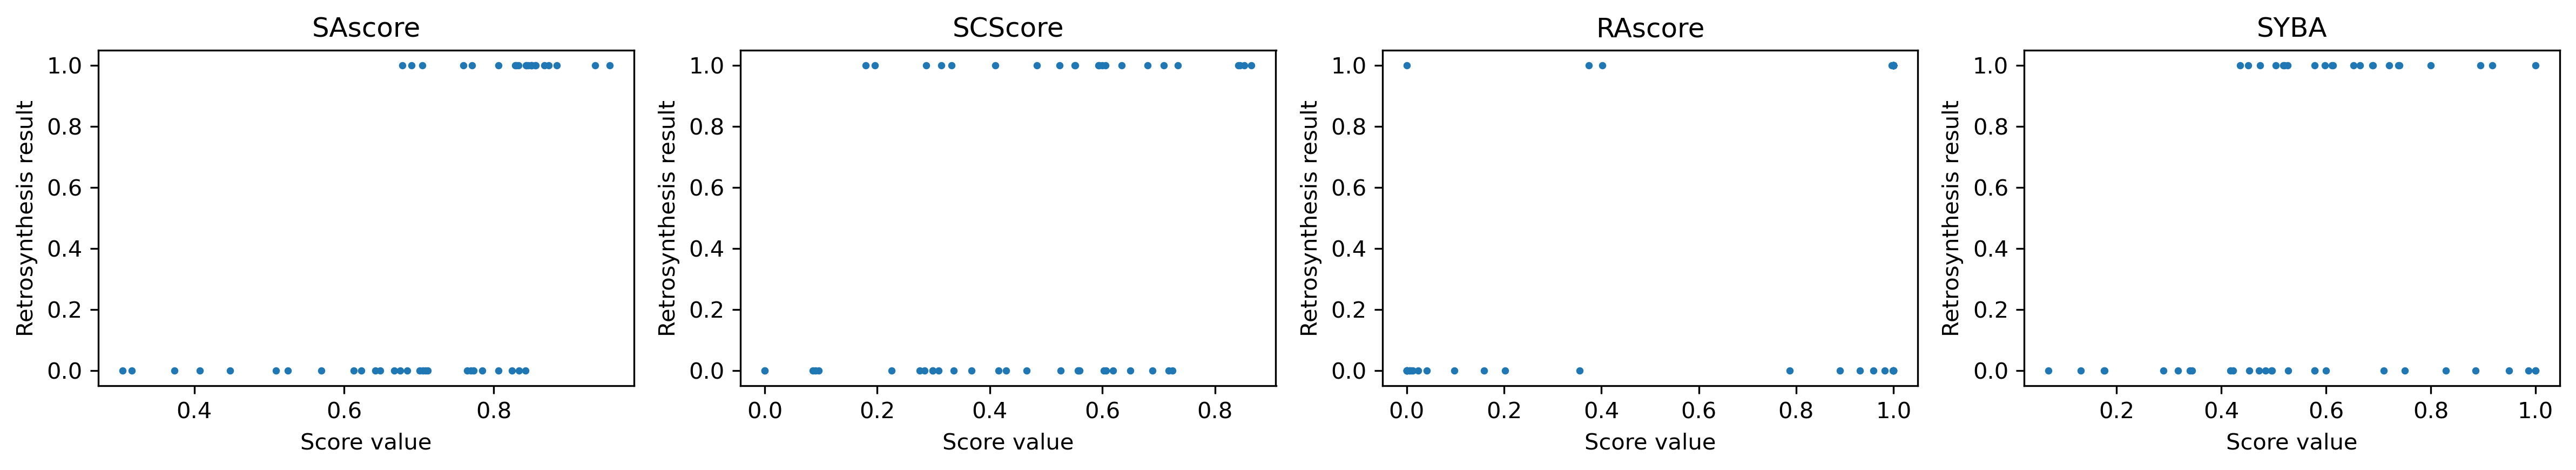

In [3]:
with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]

    rows: list[tuple[str, float,float,float]] = []
    pairs_score_characteristic: list[tuple[Score, int]] = [
        (score, 1 if type in ["internal", "solved"] else 0) for score, type, stats in tree_stats]
    pairs_per_plot = []
    for score_name, getter in Score.getters():

        pairs_per_plot.append([
            (getter(score), char_value, score_name) for score, char_value in pairs_score_characteristic])
    scatter_plot(pairs_per_plot)

The ROC curve of the above

For sa, best threshold=0.806595, G-Mean=0.829
sa AUC 0.9006734006734007
Accuracy: 0.8163265306122448
For sc, best threshold=0.483849, G-Mean=0.656
sc AUC 0.6851851851851851
Accuracy: 0.6326530612244898
For ra, best threshold=0.999568, G-Mean=0.835
ra AUC 0.8468013468013469
Accuracy: 0.8163265306122448
For syba, best threshold=0.503601, G-Mean=0.693
syba AUC 0.6616161616161617
Accuracy: 0.673469387755102


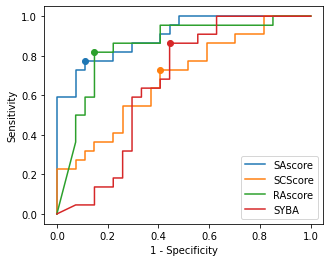

In [4]:
# ROC of the same as above

# ground truth - result of AiZynthFinder
# prediction - sa scores

fig = plt.figure(figsize=(5, 4))

with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]

    gt = np.array([1 if type in ["internal", "solved"] else 0 for _, type, _ in tree_stats])
    shitty_convoluted_scores = [score for score, _, _ in tree_stats]
    predictions = []
    for score_name, getter in Score.getters():
        single_score_predictions = [getter(score) for score in shitty_convoluted_scores]
        fpr, tpr, thresholds = metrics.roc_curve(gt, single_score_predictions)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        print('For %s, best threshold=%f, G-Mean=%.3f' % (score_name, thresholds[ix], gmeans[ix]))

        print(score_name, "AUC", metrics.auc(fpr, tpr))

        synthetis_predicted = single_score_predictions > thresholds[ix]
        synthesis_found = np.array([ts[1] in ["solved", "internal"] for ts in tree_stats])
        correctly_found = np.logical_and(synthesis_found, synthetis_predicted)
        correctly_not_found = np.logical_and(np.logical_not(synthetis_predicted),
                                             np.logical_not(synthesis_found))
        print("Accuracy:", np.sum(np.logical_or(correctly_found, correctly_not_found) / len(tree_stats)))
        plt.plot(fpr,tpr, label=name_mapping[score_name])
        plt.scatter(fpr[ix], tpr[ix], marker='o')
        plt.ylabel("Sensitivity")
        plt.xlabel("1 - Specificity")

        predictions.append(single_score_predictions)
plt.legend()        
plt.show()

### Retrosynthesis complexity

Next, we correlate the complexity of AiZynthFinder computation with synthtetic accessibility score of target molecule 

In [5]:
def corr_row(pairs_per_plot: list[list[tuple[Any, Any, str]]]):
    stats = []; pvals = []
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, in pairs]
        ys = [y for _x, y, in pairs]
        corr = spearmanr(xs, ys, alternative="less")
        stats.append(corr.correlation)
        pvals.append(corr.pvalue)
    return stats, pvals

display(HTML("First row: Spearman correlation coefficient, second: p-value"))

with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        rows = [[""]]
        title = False
        for characteristic in (#"max_depth", 
                "max_width", "node_count", "not_solved_count"):
            pairs_score_characteristic: list[tuple[Score, int]] = [
                (score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            pairs_per_plot = []
            for score_name, getter in Score.getters():
                if not title: rows[0].append(name_mapping[score_name])
                pairs_per_plot.append([
                    (getter(score), char_value) for score, char_value in pairs_score_characteristic])

            title = True
            first_row, second_row = corr_row(pairs_per_plot)
            rows.append([characteristic] + first_row)
            rows.append([""] + second_row)
        tab = tabulate.tabulate(rows, headers="firstrow", tablefmt='html')
        display(tab)

,SAscore,SCScore,RAscore,SYBA
max_width,-0.270535,-0.268136,-0.357783,-0.0248571
,0.0300483,0.0312471,0.00580161,0.432688
node_count,-0.371304,-0.25058,-0.442,-0.0810369
,0.00431131,0.0412283,0.000737318,0.289952
not_solved_count,0.569116,0.0876782,0.392644,0.24768
,0.99999,0.725433,0.997369,0.956905


In [6]:
# with Db("db", True) as db:
#     mols = data()
#     tree_stats = [get_stats(mol) for mol in mols]
#     for filter in filters:
#         for characteristic in (#"max_depth", # Checking max_depth is nonsense
#                 "max_width", "node_count", "not_solved_count"):
#             display(HTML(characteristic))
#             rows: list[tuple[str, float,float,float]] = []
#             pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
#             pairs_per_plot = []
#             for score_name, getter in Score.getters():
# #                 display(HTML(score_name))
#                 pairs_per_plot.append([(getter(score),
#                                         char_value, score_name) for score, char_value in pairs_score_characteristic])
#             scatter_plot(pairs_per_plot, ylabel="Parameter value")